Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


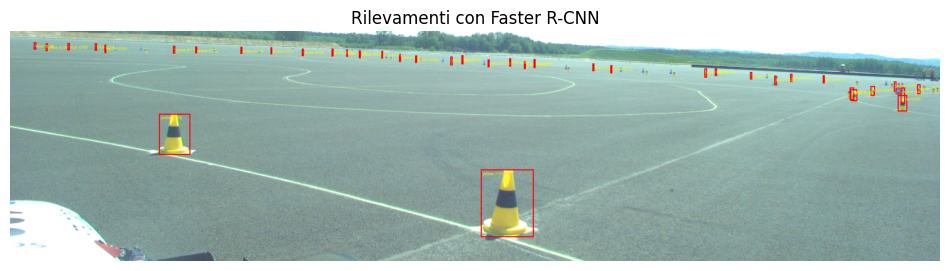

Immagine salvata in: /content/drive/MyDrive/detections_output.jpg


In [ ]:
# Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importa le librerie
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os

#  Definizione classi (4 + background)
class_names = [
    "__background__",  # label 0
    "yellow",          # label 1
    "blue",            # label 2
    "orange",          # label 3
    "large_orange" ,# label 4
    "unknown"
    ]

#  Funzione per caricare il modello
def load_model(pth_path, num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(pth_path, map_location='cpu'))
    model.eval()
    return model

#  Preprocessing immagine
def preprocess(image):
    transform = T.Compose([T.ToTensor()])
    return transform(image)

def draw_boxes(image, outputs, score_threshold=0.5):
    draw = ImageDraw.Draw(image)
    boxes = outputs["boxes"]
    scores = outputs["scores"]
    labels = outputs["labels"]

    for box, score, label in zip(boxes, scores, labels):
        if score >= score_threshold:
            box = box.tolist()
            label_id = label.item()
            class_name = class_names[label_id]
            text = f"{class_name} ({score:.2f})"
            text_location = (box[0] + 5, box[1] + 5)
            draw.rectangle(box, outline="red", width=3)
            draw.text(text_location, text, fill="yellow")
    return image

# Imposta i percorsi
model_path = "/content/drive/MyDrive/FasterRCNN/FasterNet.pth"
image_path = "/content/drive/MyDrive/FasterRCNN/amz_01369.png"

#  Controllo esistenza file
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Modello non trovato: {model_path}")
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Immagine non trovata: {image_path}")

# Carica modello e immagine
num_classes = 6
model = load_model(model_path, num_classes)

image = Image.open(image_path).convert("RGB")
image_tensor = preprocess(image)

#  Inferenza
with torch.no_grad():
    outputs = model([image_tensor])[0]

# Visualizza immagine con box
image_with_boxes = draw_boxes(image.copy(), outputs)

plt.figure(figsize=(12, 12))
plt.imshow(image_with_boxes)
plt.axis("off")
plt.title("Rilevamenti con Faster R-CNN")
plt.show()

# Salva immagine annotata su Drive
output_path = "/content/drive/MyDrive/detections_output.jpg"
image_with_boxes.save(output_path)
print(f"Immagine salvata in: {output_path}")
